# Explainer Notebook

## 1. Motivation

* What is your dataset?
* Why did you choose this/these particular dataset(s)?
* What was your goal for the end user's experience?

## 2. Basic stats. Let's understand the dataset better

* Write about your choices in data cleaning and preprocessing
* Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

In [1]:
# Installing packages
!pip install openpyxl

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import folium
import os
import time
import seaborn as sns
sns.set()
from shapely.geometry import Point
import geopandas
from shapely import wkt
import matplotlib.dates as md
import json
import requests
import geopandas as gpd
from folium.plugins import HeatMap

In this project, we are working with three main datasets:
1. A pre-processed dataset from OpenData [ref]
2. The original dataset from of the pre-processed dataset, containing the specific times that measurements were taken
3. A weather dataset from DMI.

### 2.1 Merge of the preprocessed dataset and the original dataset

The two datasets that consist of information about traffic differs on some ways. The preprocessed dataset consists of geo-locations, while the original dataset consists of the number of measurements on an hourly basis. Both aspects are important to keep, so we start by merging the two. But first, we have to load the two datasets:

In [3]:
df_tt = pd.read_csv('data/trafiktaelling.csv').drop(columns='FID')

df_traffic = pd.read_excel('data/SQL_2019.xlsx',
                            parse_dates= {"date" : ["ÅR","DATO"]})

# Transform our column to date object
df_traffic['date'] = pd.to_datetime(df_traffic['date'], format='%Y %m%d')

# Look at the 2009-2018 time window
df_traffic = df_traffic[df_traffic.date.dt.year > 2008]

The original dataset, `df_tt` has a column `t_nr`, which describes the location of the measurement. It is thus directly linked to the geolocation, which is stored in the `wkb_geometry` column. We can thus create a mapping so that we can map `t_nr` to `wkb_geometry`. We thus only need those two columns:

In [4]:
df_tt_mapping = df_tt[['t_nr', 'wkb_geometry']]

We now check for whether there are any duplicate values in terms of `t_nr` and find those values where they are duplicated:

In [5]:
t_nr_mult = df_tt_mapping.groupby('t_nr').size()
df_tt_mapping[df_tt_mapping.t_nr.isin(t_nr_mult[t_nr_mult > 1].keys())]

t_nr                                   wkb_geometry
151   478  POINT (12.564051414660698 55.706747764334814)
152   478  POINT (12.564051414660698 55.706747764334814)
182   602   POINT (12.558283833286113 55.67068892477301)
183   602   POINT (12.558283833286113 55.67068892477301)
295   775   POINT (12.55221192858649 55.697888963995155)
296   775  POINT (12.551928783743692 55.697898379062565)
427   938  POINT (12.531054185830063 55.702777372497984)
428   938  POINT (12.531054185830063 55.702777372497984)
625  7630    POINT (12.5775112256451 55.715633565490066)
626  7630    POINT (12.5775112256451 55.715633565490066)
716  9703   POINT (12.583662808767516 55.72009422647465)
717  9703   POINT (12.583662808767516 55.72009422647465)
718  9703   POINT (12.583662808767516 55.72009422647465)
751  9780   POINT (12.541106534414164 55.70465915279287)
752  9780   POINT (12.541106534414164 55.70465915279287)
821  9884                                            NaN
822  9884  POINT (12.540045341874835 55.707998921690134)
862  9930   POINT (12.591272415702276 55.67958309549209)
863  9930   POINT (12.591272415702276 55.67958309549209)

Here, it is clearly seen that each time `t_nr` is duplicated, `wkb_geometry` is also duplicated. Thus there is a direct mapping between `t_nr` and `wkb_geometry`. We also see that for `t_nr=9884`, one of the point takes a `NaN` value. Since all of the others match, we proceed with the belief that its location is the same as the other one with the same `t_nr`. We thus proceed by making a dictionary of this mapping.

Our original dataset `df_traffic` has the column `TS`, which is directly the same as the values in `t_nr`.

In [6]:
d_mapping = df_tt_mapping.drop_duplicates(subset='t_nr', keep='last').set_index('t_nr')['wkb_geometry'].to_dict()
df_traffic['wkb_geometry'] = df_traffic['TS'].map(d_mapping)

We now look for whether `wkb_geometry` has any `NaN`-values and find the corresponding street names:

In [7]:
df_traffic[df_traffic['wkb_geometry'].isna()].VEJNAVN.unique()

array(['VASBYGADE 40 v.f. Vestre Teglgade',
       'SKELBÆKGADE 30 nordvest for Kødboderne',
       'DRONNINGENSGADE 48 - ensrettet mod nordøst', 'LINNÉSGADE 12'],
      dtype=object)

After an inspection using Google Maps, we have found that none of these places are actually close to each other. Thus we make the choice of dropping the entries where the location point is `NaN` and look for other `NaN` values in our dataset

In [8]:
df_traffic.dropna(subset=['wkb_geometry'], inplace=True)
df_traffic.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31950 entries, 19610 to 148814
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          31950 non-null  datetime64[ns]
 1   TS            31950 non-null  int64         
 2   VEJNAVN       31950 non-null  object        
 3   RETNING       31849 non-null  object        
 4   KATEGORI      31950 non-null  object        
 5   ANTAL 6-7     34 non-null     float64       
 6   ANTAL 7-8     31950 non-null  float64       
 7   ANTAL 8-9     31950 non-null  float64       
 8   ANTAL 9-10    31950 non-null  float64       
 9   ANTAL 10-11   31950 non-null  float64       
 10  ANTAL 11-12   31950 non-null  float64       
 11  ANTAL 12-13   31950 non-null  float64       
 12  ANTAL 13-14   31950 non-null  float64       
 13  ANTAL 14-15   31950 non-null  float64       
 14  ANTAL 15-16   31950 non-null  float64       
 15  ANTAL 16-17   31950 non-null  f

It is seen that most of these values are in `ANTAL 6-7`, i.e. the number of samples between 6 and 7 in the morning. From **[REF]**, we know that at some point **[PLEASE WRITE WHEN]**, they switched their countings so that they counted from 7 to 19, instead of from 6 to 18. We thus drop the entries where these are `NaN`:

In [9]:
df_traffic = df_traffic[df_traffic['ANTAL 6-7'].isna()]

Going back to the geometry data, we split the column so that we get the longitude and the latitude:

In [10]:
# Convert into geometry objects
df_traffic['wkb_geometry'] = geopandas.GeoSeries.from_wkt(df_traffic['wkb_geometry'])

# Extract lon and lat for plotting
df_traffic['lon'] = df_traffic.wkb_geometry.apply(lambda p: p.x)
df_traffic['lat'] = df_traffic.wkb_geometry.apply(lambda p: p.y)

Now, let us limit our dataset to only have cars and bikes, and select those columns that we want to work with:

In [12]:
df = df_traffic[(df_traffic['KATEGORI'].str.lower() == 'personbiler') | (df_traffic['KATEGORI'].str.lower() == 'cykler + knallerter')]
df = df[['TS', 'date', 'KATEGORI', 'lon', 'lat', 'ANTAL 7-8', 'ANTAL 8-9', 
                                       'ANTAL 9-10', 'ANTAL 10-11', 'ANTAL 11-12', 'ANTAL 12-13', 
                                       'ANTAL 13-14', 'ANTAL 14-15', 'ANTAL 15-16', 'ANTAL 16-17',
                                       'ANTAL 17-18', 'ANTAL 18-19']].reset_index(drop=True)

# Translate remaining columns to English
df.rename(columns={
    "TS": "id", 
    "KATEGORI": "category",
    "ANTAL 7-8": "7-8",
    'ANTAL 8-9': '8-9',
    'ANTAL 9-10': '9-10',
    'ANTAL 10-11': '10-11', 
    'ANTAL 11-12': '11-12', 
    'ANTAL 12-13': '12-13', 
    'ANTAL 13-14': '13-14', 
    'ANTAL 14-15': '14-15', 
    'ANTAL 15-16': '15-16', 
    'ANTAL 16-17': '16-17',
    'ANTAL 17-18': '17-18', 
    'ANTAL 18-19': '18-19'
    }, inplace=True)

# Translating cars and bikes from Danish to English
cb_mapper = {'PERSONBILER': 'cars', 'CYKLER + KNALLERTER': 'bikes'}
df['category'] = df.category.map(cb_mapper)

# Sum the observations of an entire day
df['entire_day'] = df[["7-8", '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', 
                        '16-17', '17-18', '18-19']].sum(axis=1)

We now look at the evolution in terms of bikes and cars throughout a year:

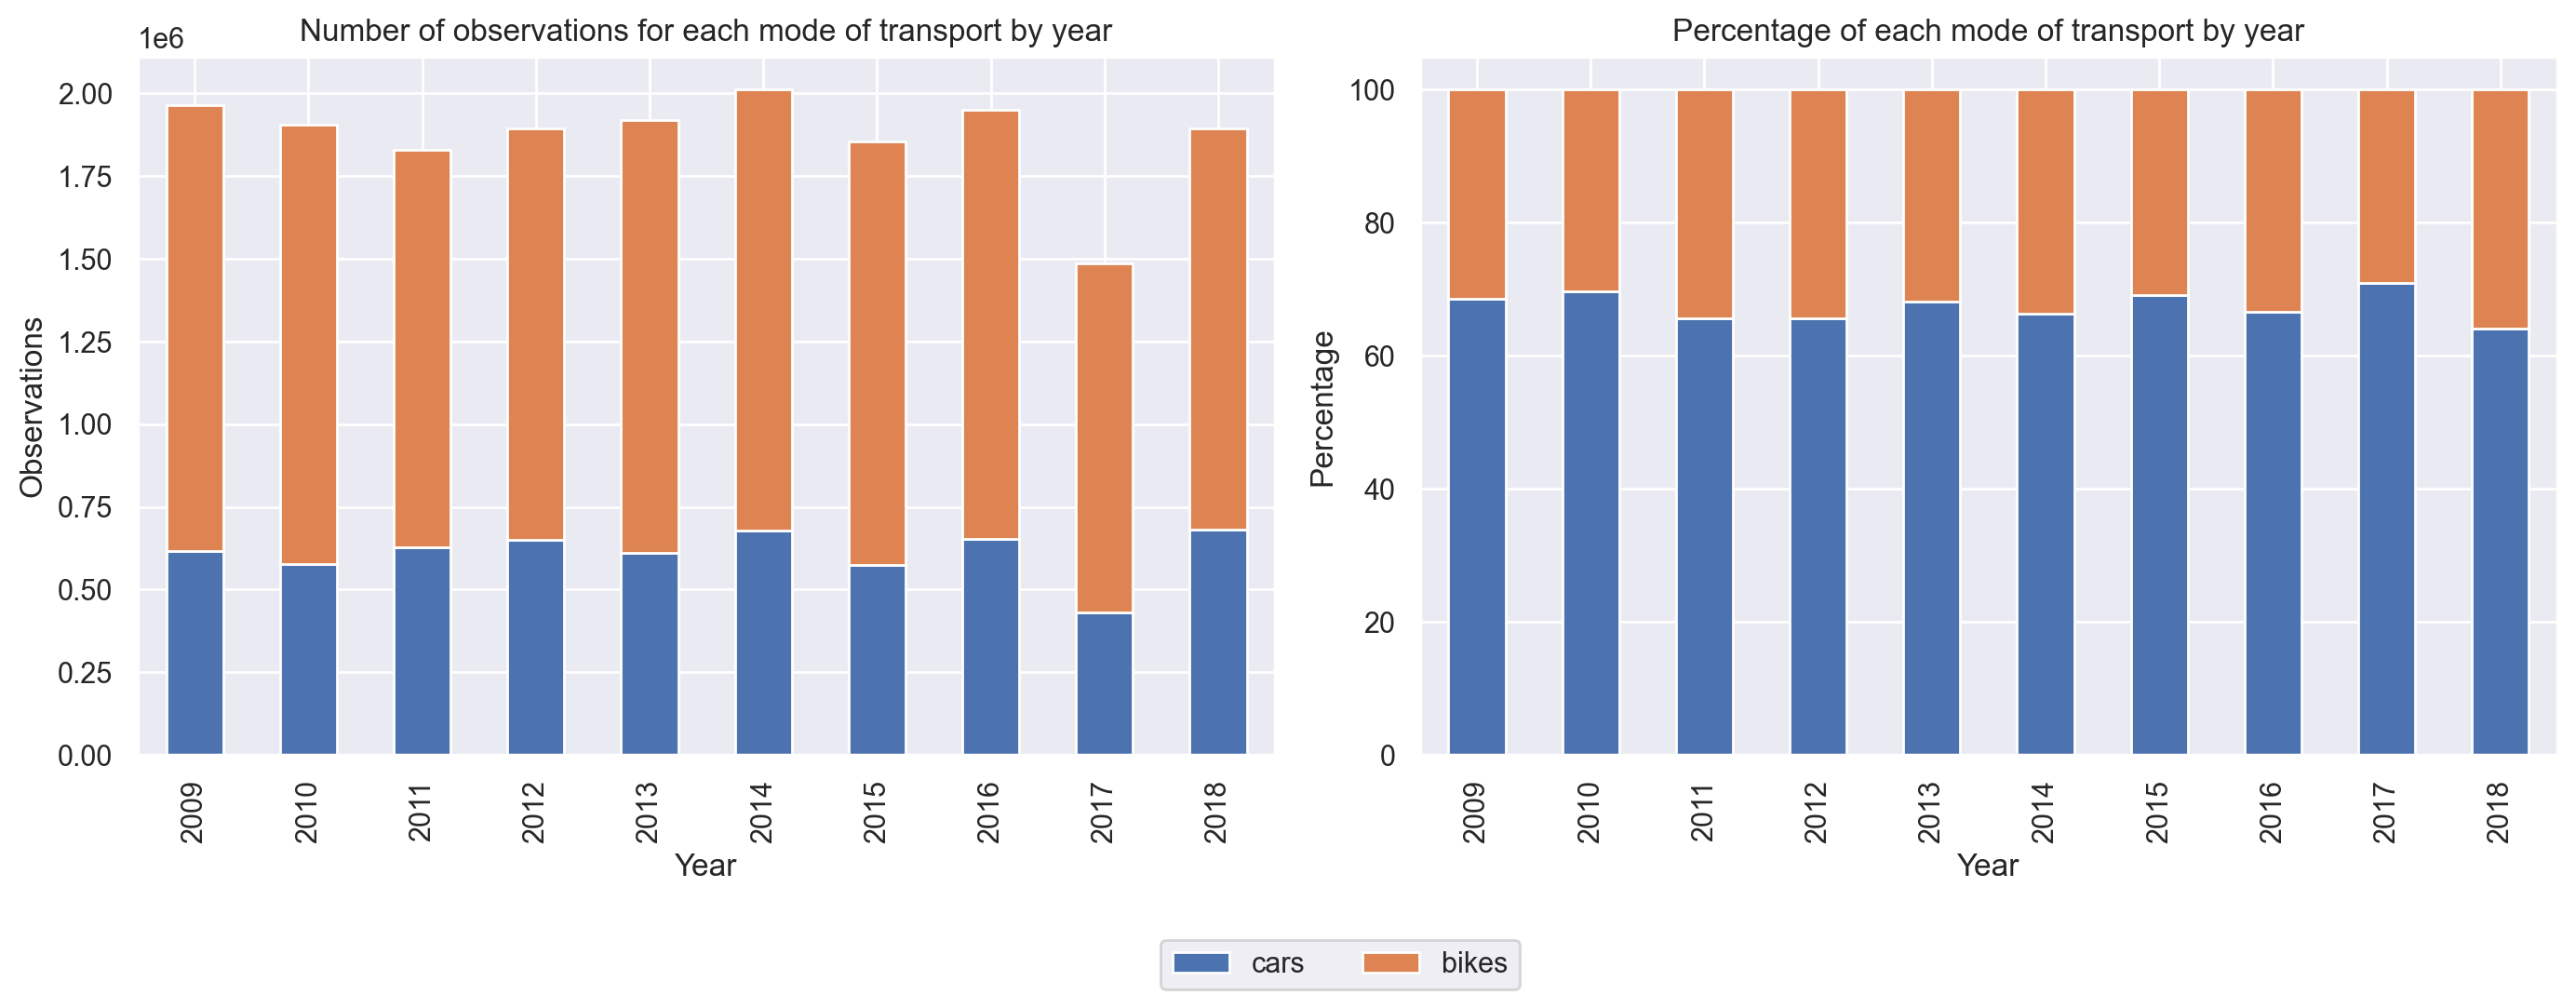

In [87]:
df['year'] = df.date.dt.year

modes_of_transport=['cars', 'bikes']

df_temp = df.groupby(['year', 'category']).sum('entire_day').reset_index()
df_year_count = pd.pivot_table(df_temp, index='year', columns=['category'], values='entire_day')

df_year_fraction = pd.DataFrame()
for i in range(len(modes_of_transport)):
    df_year_fraction[modes_of_transport[i]] = df_year_count[modes_of_transport[i]]/df_year_count.sum(axis=1)*100

fig, ax = plt.subplots(1, 2, figsize=(14,5), dpi=200)
p1 = df_year_count.plot.bar(stacked='True', ax=ax[0], 
                       title='Number of observations for each mode of transport by year',
                       xlabel='Year',
                       ylabel='Observations',
                       legend=0)

p2 = df_year_fraction.plot.bar(stacked='True', ax=ax[1], 
                       title='Percentage of each mode of transport by year',
                       xlabel='Year',
                       ylabel='Percentage',
                       legend=0)

plt.tight_layout()
plt.legend(loc='right', bbox_to_anchor=(0.1, -0.3), ncol=5)
plt.show()

We see that the number of observations taken for each year is the same for each year, with a dip when it comes to 2017. But other than that, the levels seem quite stable during the 10 years, with cars being the dominant group.

In an ideal world, we would automatically capture the number of cars, bikes etc. all 365 days of the year at the same locations each time. But as it is manually counted data, we want to inspect how many places have been counted each day:

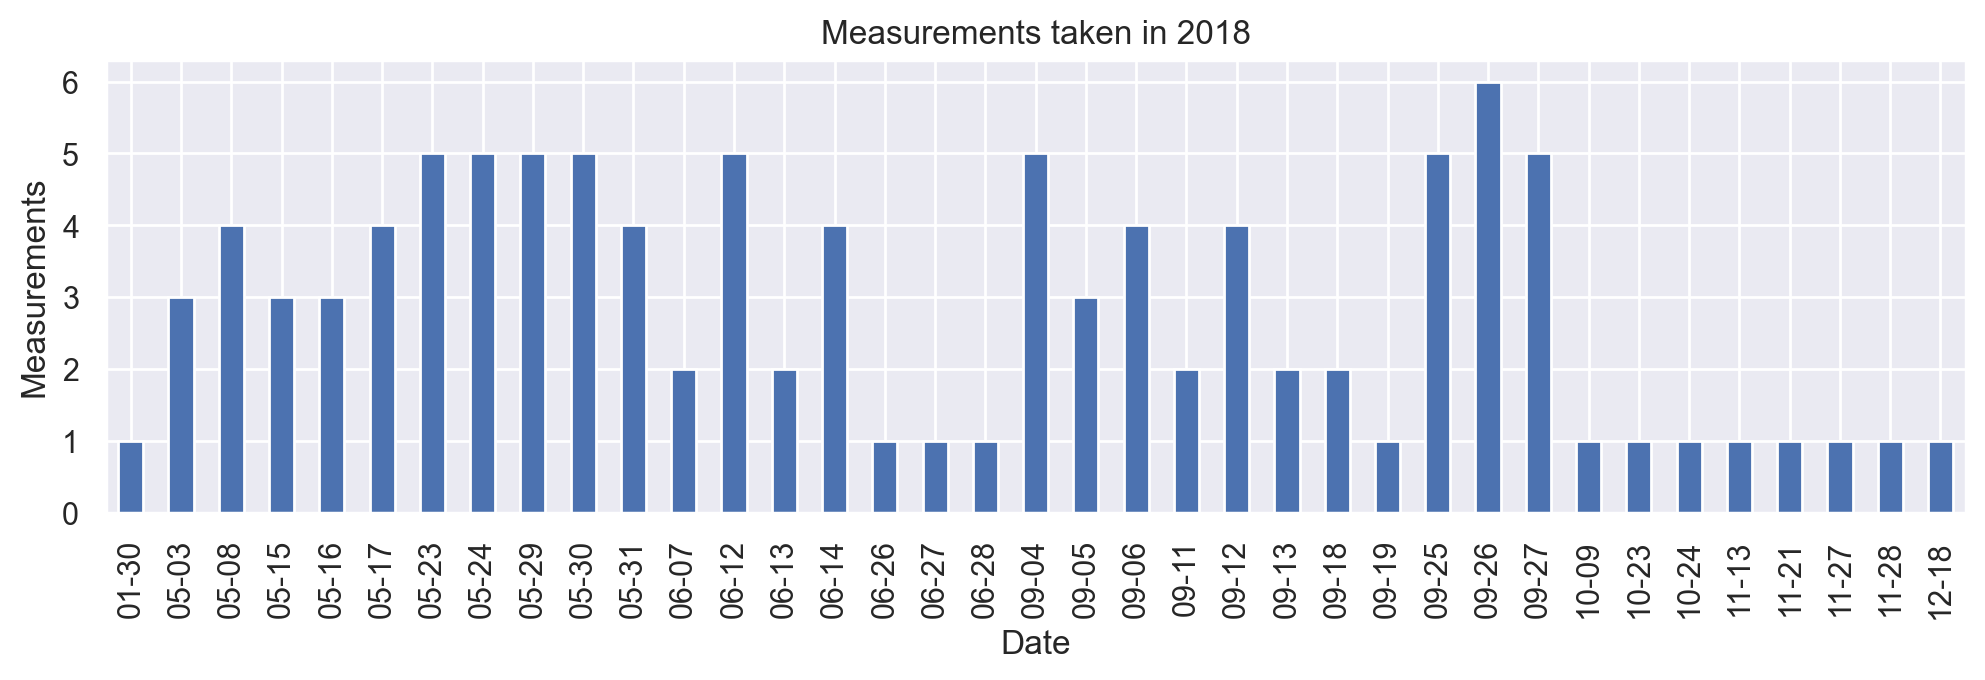

In [110]:
df_2018_measurements = df[df.year == 2018].groupby(['date']).id.nunique()

fig, ax = plt.subplots(figsize=(12,3), dpi=200)
df_2018_measurements.plot(kind='bar',
                          ax=ax,
                          xlabel='Date',
                          ylabel='Measurements',
                          title='Measurements taken in 2018')
ax.set_xticklabels([x.strftime("%m-%d") for x in df_2018_measurements.index])
plt.show()

As we see, there is also a lot of variation in terms of how many places that are counted each day. Some days, there has only one measurement place, where at other places, there have been countings at multiple locations. This causes problems, since the more places you count, the more observations you will get.

It also seems to be that during the Spring and Fall months, more measurements have been taken. We can try and plot the total observations, i.e. the sum of observations for each month throughout our time period:

In [127]:
df_month_count

category      bikes       cars
month                         
1            2916.0     6724.0
4          492613.0  2158424.0
5         1349012.0  4328025.0
6          352930.0  1400484.0
8           15230.0    56340.0
9         3243533.0  3613647.0
10         622098.0   887869.0
11          19015.0   139578.0
12           1904.0    15348.0

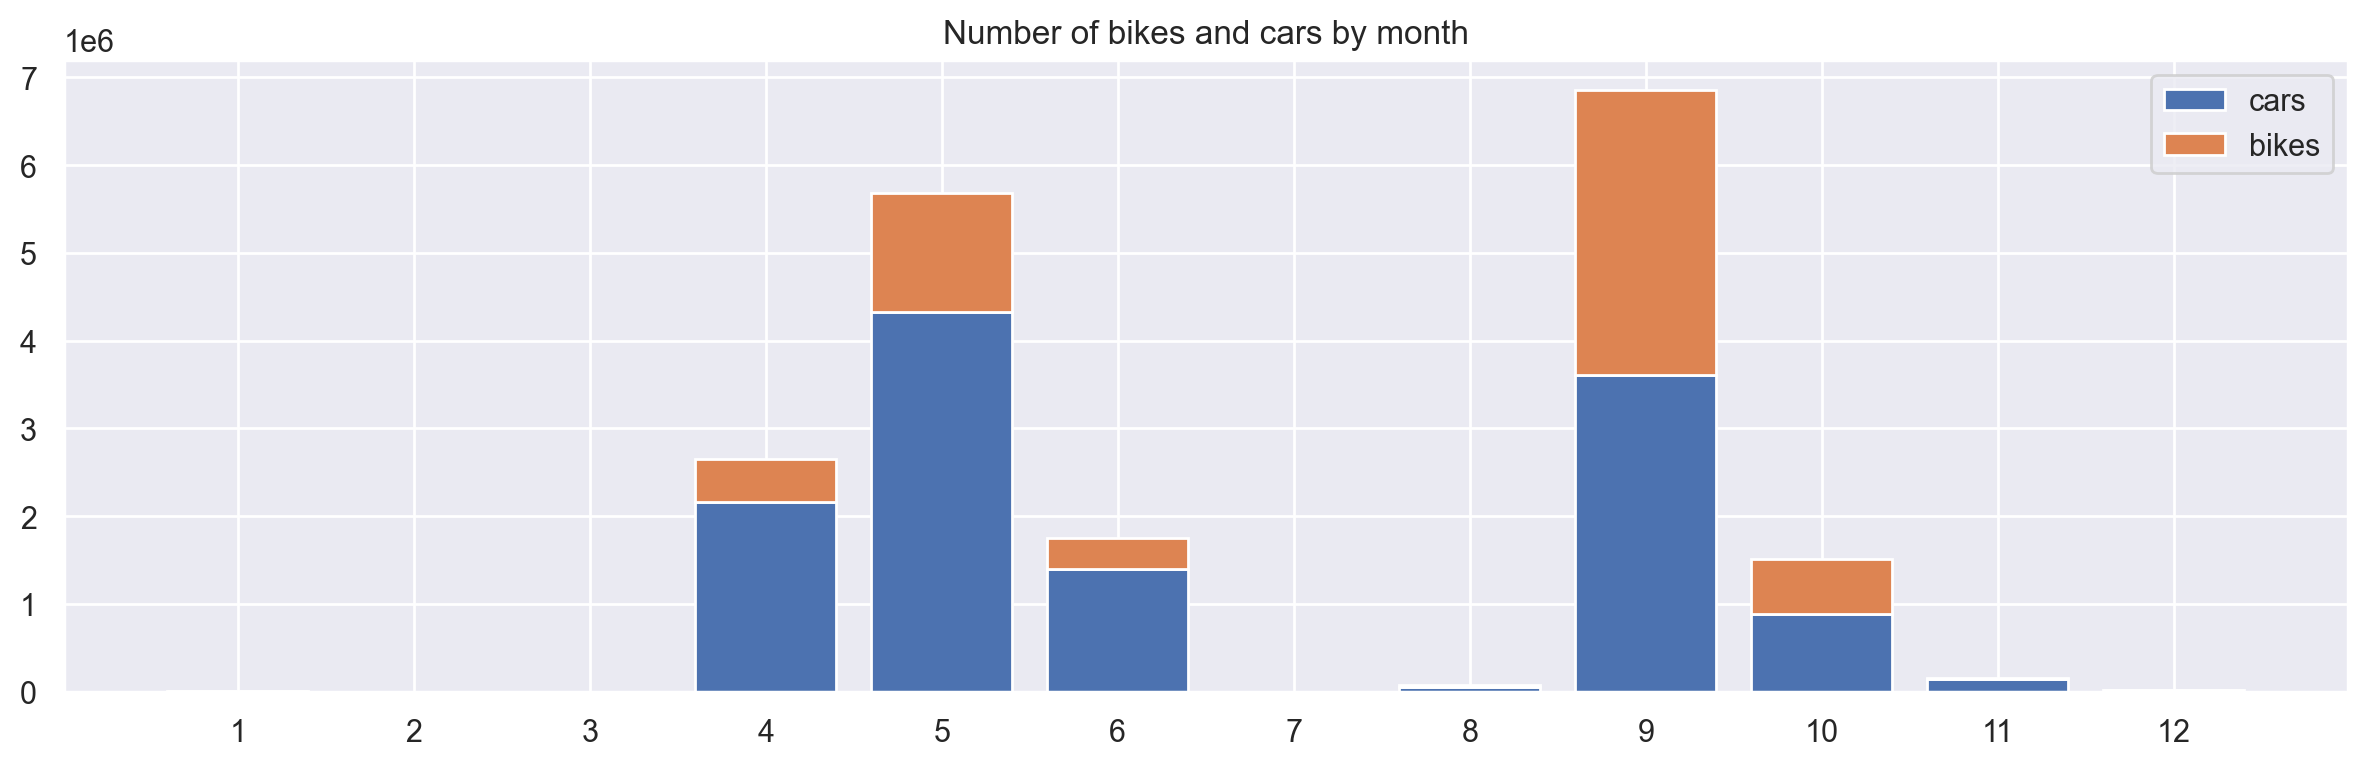

In [197]:
df['month'] = df['date'].dt.month
df_temp = df.groupby(['month', 'category']).sum('entire_day').reset_index()
df_month_count = pd.pivot_table(df_temp, index='month', columns=['category'], values='entire_day')

plt.figure(figsize=(12,4), dpi=200)
plt.bar(df_temp[df_temp.category == 'cars'].month, df_temp[df_temp.category == 'cars'].entire_day, label='cars')
plt.bar(df_temp[df_temp.category == 'bikes'].month, df_temp[df_temp.category == 'bikes'].entire_day,
        bottom = df_temp[df_temp.category == 'cars'].entire_day, label='bikes')
plt.xticks(range(1,13))
plt.title('Number of bikes and cars by month')

plt.tight_layout()
plt.legend()
plt.show()

It becomes very apparent that the measurements are mainly taken in April-June and September-October (some may argue that it is actually September-November). 

According to **[REF TIL AASES PDF]**, the measurements are taken during Spring and Fall. In Spring, measurements are taken of vehicles and bicycles - not pedestrians, while in Fall, measurements are also taken on vehicles and bicycles, but also pedestrians on certain locations. 

Besides these measurements, the municipality also runs a rotation program, where all of the neighbourhoods/districts within Copenhagen are measured. Here, vehicles and bycicles are counted, but not pedestrians. This is to ensure that we get a picture of the traffic in the entire city. They also do what they call "Other measurements", which are measurements provided for institutions (Aarhus University and Vejdirektoratet).

We also want to expect where these measurements have been taken:

In [21]:
# plot a map of Copenhagen
map_hooray = folium.Map(location=[55.676098, 12.568337],
                    zoom_start = 12,dpi=500)

# Plotting the points using folium's CircleMarker
# Loop over data, and include a couple extra information for each crime
for lng, lat in zip(df.lon, df.lat):
    folium.CircleMarker([lat, lng], radius=1.5,
                         fill=True
                         ).add_to(map_hooray)

# Show the map
map_hooray

So, most of the places where measurements have been taken are at larger/main roads. We see that there are large clusters around central Copenhagen, Vesterbro and Nørrebro, not surprisingly as these areas are very populated.

For our further analysis, this also means that there are definitely things that we have to take into account when working with this dataset:
1. It is difficult to look at all locations and see look for changes in terms of cars and bikes over an entire year, since the number of measurements is not constant.

2. We cannot take out specific point locations on the map and look for changes in those. Instead, we could look for roads or neighbourhoods within Copenhagen, to look for changes in a much larger area. This could be by creating heatmaps, or subdividing it into neighbourhoods and taking the sum of observations.

## 3. Data Analysis

* Describe your data analysis and explain what you've learned about the dataset. 
* If relevant, talk about your machine-learning.

### 3.1 Temporal Patterns

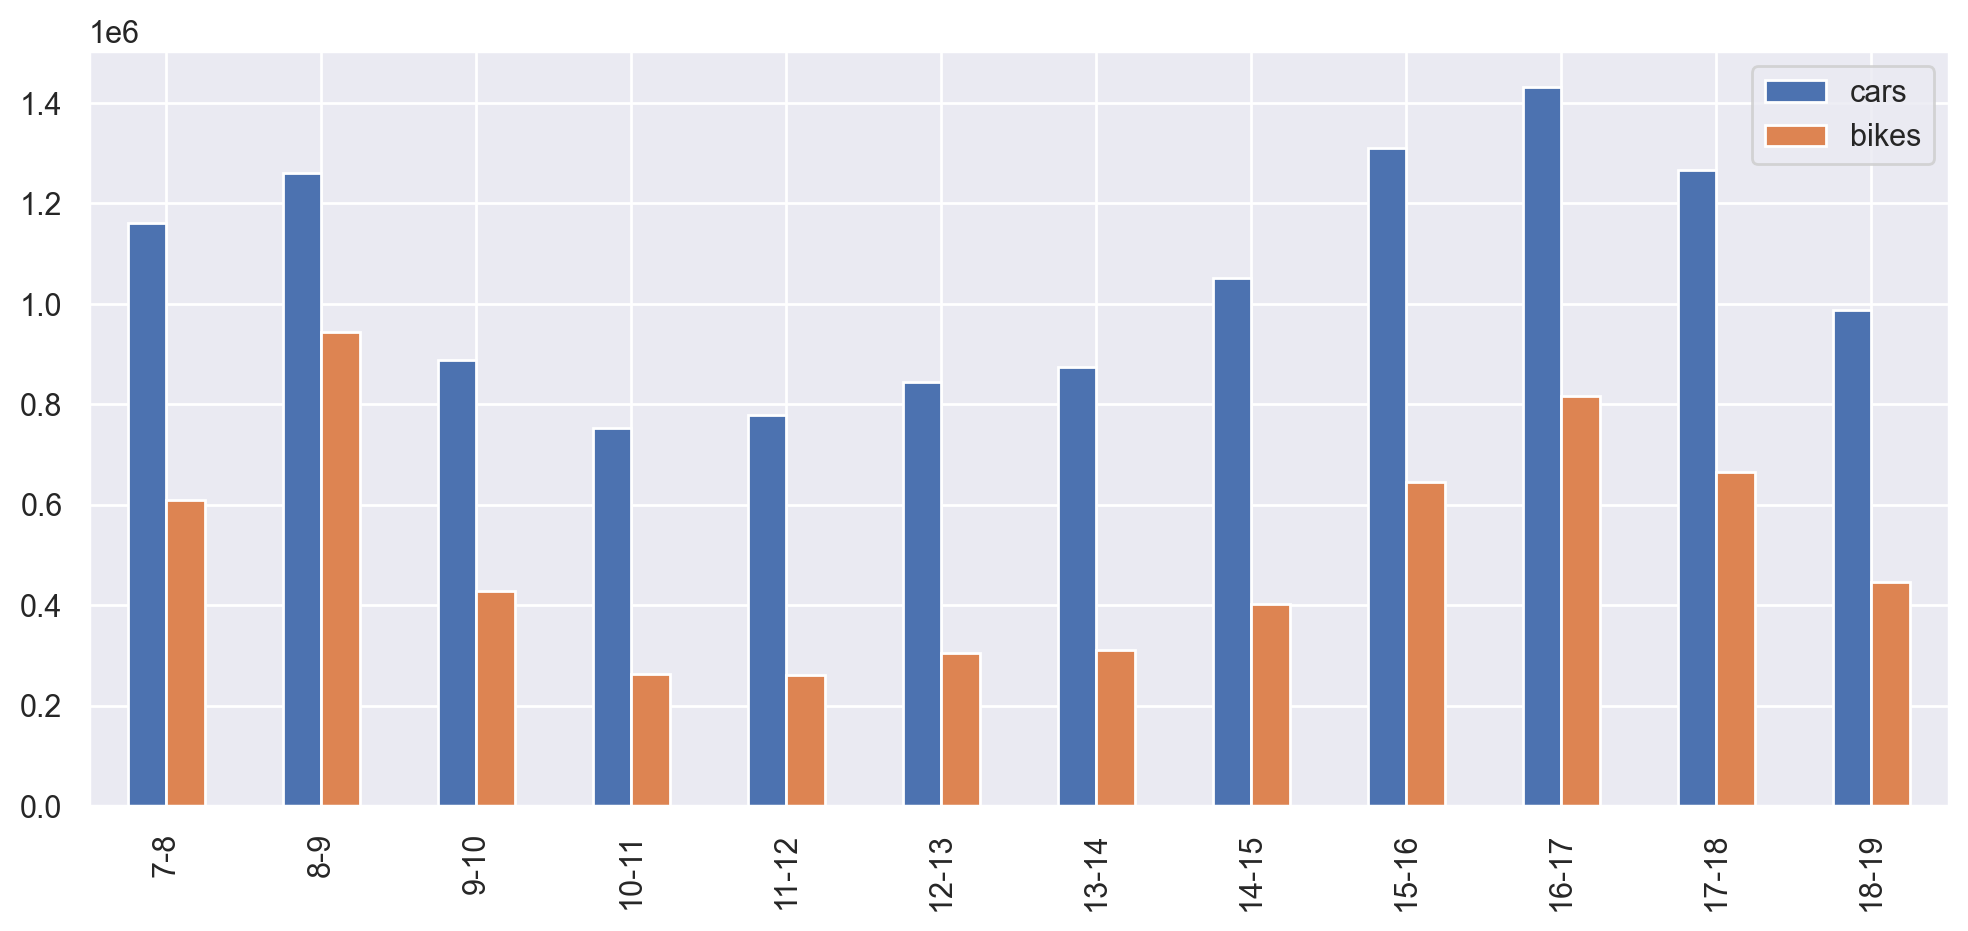

In [200]:
df_cars = df[df.category == 'cars']
df_bikes = df[df.category == 'bikes']

df_traffic_hour = pd.DataFrame()
df_traffic_hour['cars'] = df_cars[["7-8", '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', 
                        '16-17', '17-18', '18-19']].sum()
df_traffic_hour['bikes'] = df_bikes[["7-8", '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', 
                        '16-17', '17-18', '18-19']].sum()

fig, axes = plt.subplots(figsize=(12,5), dpi=200, sharex='all')
df_traffic_hour.plot(kind='bar', ax=axes)
plt.show()

### 3.2 Spatial Patterns

In [202]:
df

id       date category        lon        lat    7-8    8-9   9-10  \
0      117 2009-04-30     cars  12.534035  55.701692  276.0  417.0  305.0   
1      117 2009-04-30    bikes  12.534035  55.701692  345.0  492.0  264.0   
2      117 2009-04-30     cars  12.534035  55.701692  327.0  535.0  397.0   
3      117 2009-04-30    bikes  12.534035  55.701692  355.0  883.0  553.0   
4      122 2009-09-03     cars  12.556001  55.673821  225.0  338.0  279.0   
...    ...        ...      ...        ...        ...    ...    ...    ...   
4062  9865 2018-05-17    bikes  12.557000  55.719015  639.0  884.0  184.0   
4063  9889 2018-05-29     cars  12.492646  55.684855  164.0  197.0   96.0   
4064  9889 2018-05-29    bikes  12.492646  55.684855  160.0  135.0   82.0   
4065  9889 2018-05-29     cars  12.492646  55.684855  250.0  287.0  179.0   
4066  9889 2018-05-29    bikes  12.492646  55.684855  384.0  362.0  133.0   

      10-11  11-12  12-13  13-14  14-15  15-16  16-17  17-18  18-19  \
0     329.0  392.0  430.0  453.0  538.0  551.0  469.0  493.0  516.0   
1     218.0  250.0  260.0  262.0  425.0  621.0  847.0  751.0  580.0   
2     405.0  441.0  464.0  457.0  536.0  517.0  618.0  636.0  456.0   
3     353.0  355.0  347.0  295.0  379.0  507.0  541.0  499.0  358.0   
4     283.0  331.0  370.0  373.0  432.0  466.0  642.0  568.0  438.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...   
4062   92.0   77.0  100.0  121.0  187.0  381.0  380.0  347.0  194.0   
4063  128.0  114.0  148.0  157.0  193.0  297.0  246.0  204.0  142.0   
4064   67.0   73.0   90.0  152.0  204.0  346.0  353.0  225.0  164.0   
4065  146.0  116.0  115.0  163.0  167.0  212.0  255.0  184.0  140.0   
4066   81.0   88.0   69.0   91.0  111.0  173.0  222.0  132.0  100.0   

      entire_day  year  month  
0         5169.0  2009      4  
1         5315.0  2009      4  
2         5789.0  2009      4  
3         5425.0  2009      4  
4         4745.0  2009      9  
...          ...   ...    ...  
4062      3586.0  2018      5  
4063      2086.0  2018      5  
4064      2051.0  2018      5  
4065      2214.0  2018      5  
4066      1946.0  2018      5  

[4067 rows x 20 columns]

In [201]:
# Aggregating by Zone
df = df.groupby('zone').sum()
df = df.reset_index(drop=False)

# Displaying result
df.head()

KeyError: 'zone'

In [204]:
# Import copenhagen districts (ref: https://giedriusk.carto.com/tables/copenhagen_districts/public)
districts = gpd.read_file('data/copenhagen_districts.geojson')

# Find unique districts
df_districts = pd.DataFrame(districts['name'].unique(), columns=["DISTRICTS"])
df_districts['VALUES'] = 0

In [211]:
# Plot heatmap with districts

# import copenhagen districts as json
with open('data/copenhagen_districts.geojson') as f:
    data = json.load(f)

Choropleth = folium.Choropleth(geo_data=data, data=df_districts, columns=['DISTRICTS', 'VALUES'], key_on='feature.properties.name', fill_opacity=0, line_opacity=1, line_weight=2)
# Adding the data to the map
Choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['name']))

# Deleting legend bar for the color schema (If we have fill_opacity = 0)
for keys in Choropleth._children:
    if keys.startswith('color_map'):
        del(Choropleth._children[keys])

# Finding the relevant lon and lat coordinates
heat_data = [[row['lat'], row['lon'], row['entire_day']] for index, row in df_bikes.iterrows()]

# Creating the map
map_copenhagen = folium.Map(location=[55.676098, 12.568337],
                    zoom_start = 12,dpi=500)

# Adding Districts
Choropleth.add_to(map_copenhagen)

# Adding the data to the map
HeatMap(heat_data, radius=15, blur=25).add_to(map_copenhagen)


# Adding color palette
map_copenhagen

In [212]:
# Finding the relevant lon and lat coordinates
heat_data = [[row['lat'], row['lon'], row['entire_day']] for index, row in df_cars.iterrows()]

# Creating the map
map_copenhagen = folium.Map(location=[55.676098, 12.568337],
                    zoom_start = 12,dpi=500)

# Adding Districts
Choropleth.add_to(map_copenhagen)

# Adding the data to the map
HeatMap(heat_data, radius=15, blur=25).add_to(map_copenhagen)


# Adding color palette
map_copenhagen

### 3.3 Weather

In [213]:
# Copenhagen
# (lon, lat) 12.447848,55.606376,12.692826,55.731079

url = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'

header={'X-Gravitee-Api-Key': '4017479a-aed9-4909-aaac-0cb6169d7743'} #hidden 

# Parameters: https://confluence.govcloud.dk/pages/viewpage.action?pageId=26476616
param_list = ['temp_mean_past1h','wind_speed_past1h','precip_past1h']

#Construct weather dataframe
df_weather = pd.DataFrame()

for param in param_list:

    # Specify query parameters
    params = {'datetime' : '2009-01-01T00:00:00Z/2018-12-31T23:59:00Z',
            'parameterId' : param,
            'limit' : '300000',
            # Use bbox from above
            'bbox' : '12.447848,55.606376,12.692826,55.731079'
            }


    r = requests.get(url,headers=header,params=params) # submit GET request based on url and headers
    json_t = r.json()['features']
    df_weather_t = pd.json_normalize(json_t)
    df_weather = pd.concat([df_weather, df_weather_t])

### Data preprocessing

In [214]:
# Convert to 'datetime'
df_weather['properties.observed'] = pd.to_datetime(df_weather['properties.observed']).dt.tz_localize(None)

# Save columns including date and time
df_weather['date'] = pd.to_datetime(df_weather['properties.observed']).dt.date
df_weather['time'] = pd.to_datetime(df_weather['properties.observed']).dt.time

# Select coloumns of interest
df_weather = df_weather[['geometry.coordinates', 'properties.observed', 'date', 'time', 'properties.parameterId', 'properties.value']]

In [215]:
df_temp = df_weather[df_weather['properties.parameterId'] == 'temp_mean_past1h'].groupby(pd.Grouper(key='date')).agg({ 'properties.value': 'mean'})
#df_wind = df_weather[df_weather['properties.parameterId'] == 'wind_speed_past1h'].groupby(pd.Grouper(key='properties.observed')).agg({ 'properties.value': 'mean'})
#df_precip = df_weather[df_weather['properties.parameterId'] == 'precip_past1h'].groupby(pd.Grouper(key='properties.observed')).agg({ 'properties.value': 'mean'})

In [217]:
df

id       date category        lon        lat    7-8    8-9   9-10  \
0      117 2009-04-30     cars  12.534035  55.701692  276.0  417.0  305.0   
1      117 2009-04-30    bikes  12.534035  55.701692  345.0  492.0  264.0   
2      117 2009-04-30     cars  12.534035  55.701692  327.0  535.0  397.0   
3      117 2009-04-30    bikes  12.534035  55.701692  355.0  883.0  553.0   
4      122 2009-09-03     cars  12.556001  55.673821  225.0  338.0  279.0   
...    ...        ...      ...        ...        ...    ...    ...    ...   
4062  9865 2018-05-17    bikes  12.557000  55.719015  639.0  884.0  184.0   
4063  9889 2018-05-29     cars  12.492646  55.684855  164.0  197.0   96.0   
4064  9889 2018-05-29    bikes  12.492646  55.684855  160.0  135.0   82.0   
4065  9889 2018-05-29     cars  12.492646  55.684855  250.0  287.0  179.0   
4066  9889 2018-05-29    bikes  12.492646  55.684855  384.0  362.0  133.0   

      10-11  11-12  12-13  13-14  14-15  15-16  16-17  17-18  18-19  \
0     329.0  392.0  430.0  453.0  538.0  551.0  469.0  493.0  516.0   
1     218.0  250.0  260.0  262.0  425.0  621.0  847.0  751.0  580.0   
2     405.0  441.0  464.0  457.0  536.0  517.0  618.0  636.0  456.0   
3     353.0  355.0  347.0  295.0  379.0  507.0  541.0  499.0  358.0   
4     283.0  331.0  370.0  373.0  432.0  466.0  642.0  568.0  438.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...   
4062   92.0   77.0  100.0  121.0  187.0  381.0  380.0  347.0  194.0   
4063  128.0  114.0  148.0  157.0  193.0  297.0  246.0  204.0  142.0   
4064   67.0   73.0   90.0  152.0  204.0  346.0  353.0  225.0  164.0   
4065  146.0  116.0  115.0  163.0  167.0  212.0  255.0  184.0  140.0   
4066   81.0   88.0   69.0   91.0  111.0  173.0  222.0  132.0  100.0   

      entire_day  year  month  
0         5169.0  2009      4  
1         5315.0  2009      4  
2         5789.0  2009      4  
3         5425.0  2009      4  
4         4745.0  2009      9  
...          ...   ...    ...  
4062      3586.0  2018      5  
4063      2086.0  2018      5  
4064      2051.0  2018      5  
4065      2214.0  2018      5  
4066      1946.0  2018      5  

[4067 rows x 20 columns]

In [218]:
df_temp

properties.value
date                        
2018-12-31          5.120833
2018-12-30          4.714583
2018-12-29          6.904167
2018-12-28          6.308333
2018-12-27          7.918750
...                      ...
2009-01-05         -5.068750
2009-01-04         -2.816667
2009-01-03          1.170833
2009-01-02         -3.112766
2009-01-01         -0.702083

[3652 rows x 1 columns]

In [219]:
df_precip['datetime'] = pd.to_datetime(df_precip.index)
df_precip['date'] = pd.to_datetime(df_precip['datetime']).dt.date
df_precip['time'] = pd.to_datetime(df_precip['datetime']).dt.time

NameError: name 'df_precip' is not defined

## 4. Genre.

* Which genre of data story did you use?
* Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
* Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?


## 5. Visualizations.


* Explain the visualizations you've chosen.
* Why are they right for the story you want to tell?

## 6. Discussion. Think critically about your creation

* What went well?
* What is still missing? What could be improved? Why?

## Contributions. Who did what?

* You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).
* It is not OK simply to write "All group members contributed equally".

In [ ]:
pd.DataFrame({'Mean': df_year_count.mean(), 'Median': df_year_count.median(), 'Standard Deviation': df_year_count.std()}).round(decimals=2)

Mean    Median  Standard Deviation
cars               367173.27  286021.0           392750.50
bikes              208779.36  120048.0           198244.31
pedestrians         99031.45   65641.0            83254.15
trucks               7540.36    3310.0            10366.71
electric scooters     552.91       0.0             1833.79

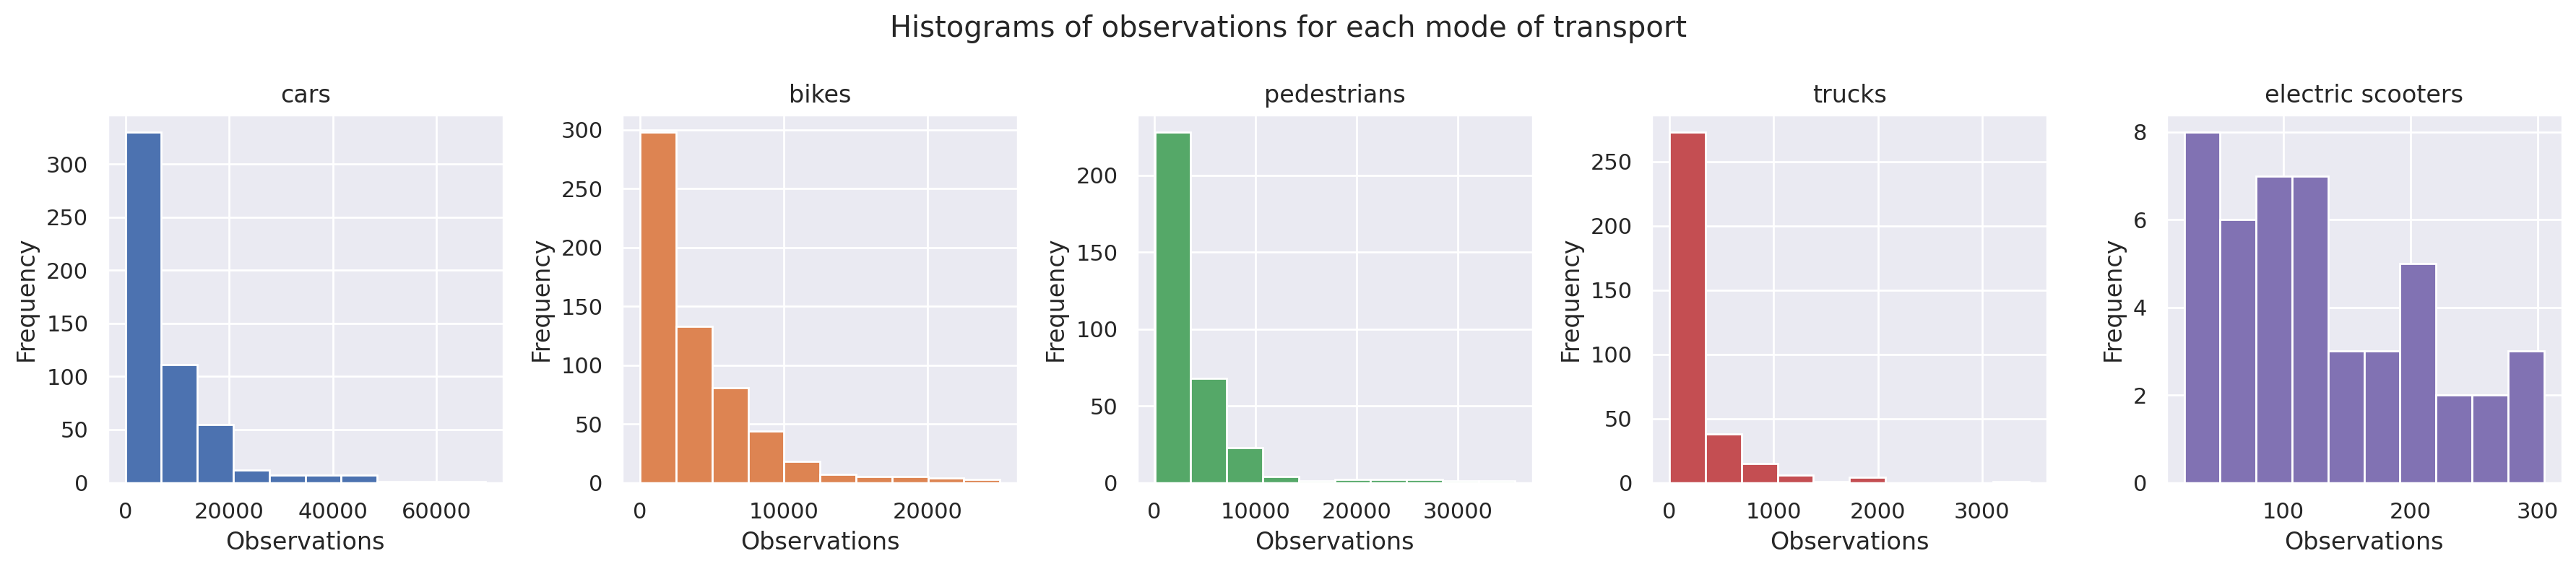

In [ ]:
palette = sns.color_palette()

fig, axes = plt.subplots(1,5, figsize=(18,4), dpi=200)
for i in range(len(modes_of_transport)):
    df_tt[[modes_of_transport[i]]].hist(ax=axes[i], color= palette[i])
    axes[i].set_xlabel("Observations")
    axes[i].set_ylabel("Frequency")
fig.suptitle('Histograms of observations for each mode of transport')
plt.tight_layout()
#plt.savefig('Histograms.png')
plt.show()

## Time Data

In [ ]:
# Data preparation
df_traffic = pd.read_excel('data/SQL_2019.xlsx')
df_traffic

ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 1.0.0 for Excel support Use pip or conda to install xlrd.

In [ ]:
# Merge the two dataframes to get coordinates (t_nr and TS keys)
df_merged = df_traffic_filter.merge(df_tt[['t_nr', 'lon', 'lat']], left_on='t_nr', right_on='t_nr', how='outer')

In [ ]:
df_merged

t_nr        date             category    7-8    8-9   9-10  10-11  \
0       117  2009-04-30          PERSONBILER  276.0  417.0  305.0  329.0   
1       117  2009-04-30  CYKLER + KNALLERTER  345.0  492.0  264.0  218.0   
2       117  2009-04-30          PERSONBILER  327.0  535.0  397.0  405.0   
3       117  2009-04-30  CYKLER + KNALLERTER  355.0  883.0  553.0  353.0   
4       117  2010-05-06          PERSONBILER  274.0  336.0  255.0  318.0   
...     ...         ...                  ...    ...    ...    ...    ...   
4367  10151         NaN                  NaN    NaN    NaN    NaN    NaN   
4368  10176         NaN                  NaN    NaN    NaN    NaN    NaN   
4369  10190         NaN                  NaN    NaN    NaN    NaN    NaN   
4370  10192         NaN                  NaN    NaN    NaN    NaN    NaN   
4371  10193         NaN                  NaN    NaN    NaN    NaN    NaN   

      11-12  12-13  13-14  14-15  15-16  16-17  17-18  18-19        lon  \
0     392.0  430.0  453.0  538.0  551.0  469.0  493.0  516.0        NaN   
1     250.0  260.0  262.0  425.0  621.0  847.0  751.0  580.0        NaN   
2     441.0  464.0  457.0  536.0  517.0  618.0  636.0  456.0        NaN   
3     355.0  347.0  295.0  379.0  507.0  541.0  499.0  358.0        NaN   
4     397.0  456.0  416.0  506.0  556.0  550.0  381.0  472.0        NaN   
...     ...    ...    ...    ...    ...    ...    ...    ...        ...   
4367    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  12.569577   
4368    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  12.570894   
4369    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  12.569539   
4370    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  12.555246   
4371    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  12.557037   

            lat  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
4367  55.683120  
4368  55.696426  
4369  55.702337  
4370  55.691003  
4371  55.689020  

[4372 rows x 17 columns]

In [ ]:
df_traffic_filter

t_nr  year  date             category    7-8    8-9   9-10  10-11  \
19610    117  2009   430          PERSONBILER  276.0  417.0  305.0  329.0   
19622    117  2009   430  CYKLER + KNALLERTER  345.0  492.0  264.0  218.0   
19624    117  2009   430          PERSONBILER  327.0  535.0  397.0  405.0   
19636    117  2009   430  CYKLER + KNALLERTER  355.0  883.0  553.0  353.0   
19648    122  2009   903          PERSONBILER  225.0  338.0  279.0  283.0   
...      ...   ...   ...                  ...    ...    ...    ...    ...   
148364  9865  2018   517  CYKLER + KNALLERTER  639.0  884.0  184.0   92.0   
148426  9889  2018   529          PERSONBILER  164.0  197.0   96.0  128.0   
148438  9889  2018   529  CYKLER + KNALLERTER  160.0  135.0   82.0   67.0   
148440  9889  2018   529          PERSONBILER  250.0  287.0  179.0  146.0   
148452  9889  2018   529  CYKLER + KNALLERTER  384.0  362.0  133.0   81.0   

        11-12  12-13  13-14  14-15  15-16  16-17  17-18  18-19   date_new  
19610   392.0  430.0  453.0  538.0  551.0  469.0  493.0  516.0 1900-04-30  
19622   250.0  260.0  262.0  425.0  621.0  847.0  751.0  580.0 1900-04-30  
19624   441.0  464.0  457.0  536.0  517.0  618.0  636.0  456.0 1900-04-30  
19636   355.0  347.0  295.0  379.0  507.0  541.0  499.0  358.0 1900-04-30  
19648   331.0  370.0  373.0  432.0  466.0  642.0  568.0  438.0 1900-09-03  
...       ...    ...    ...    ...    ...    ...    ...    ...        ...  
148364   77.0  100.0  121.0  187.0  381.0  380.0  347.0  194.0 1900-05-17  
148426  114.0  148.0  157.0  193.0  297.0  246.0  204.0  142.0 1900-05-29  
148438   73.0   90.0  152.0  204.0  346.0  353.0  225.0  164.0 1900-05-29  
148440  116.0  115.0  163.0  167.0  212.0  255.0  184.0  140.0 1900-05-29  
148452   88.0   69.0   91.0  111.0  173.0  222.0  132.0  100.0 1900-05-29  

[4075 rows x 17 columns]

In [ ]:
# Take values from 2009
df = df_merged[df_merged['ÅR'] >= 2009]

# Filter away nan values
df = df[~df['wkb_geometry'].isna()]

In [ ]:
df

TS                                     VEJNAVN    ÅR  DATO  \
19834    117  FREDERIKSSUNDSVEJ øst for Frederiksborgvej  2009   430   
19835    117  FREDERIKSSUNDSVEJ øst for Frederiksborgvej  2009   430   
19836    117  FREDERIKSSUNDSVEJ øst for Frederiksborgvej  2009   430   
19837    117  FREDERIKSSUNDSVEJ øst for Frederiksborgvej  2009   430   
19838    117  FREDERIKSSUNDSVEJ øst for Frederiksborgvej  2009   430   
...      ...                                         ...   ...   ...   
150182  7635                             VESTERBROGADE 3  2018   620   
150183  7635                             VESTERBROGADE 3  2018   620   
150184  7635                             VESTERBROGADE 3  2018   620   
150185  7635                             VESTERBROGADE 3  2018   620   
150186  7635                             VESTERBROGADE 3  2018   620   

                        RETNING                 KATEGORI  ANTAL 6-7  \
19834                  FRA BYEN              PERSONBILER        NaN   
19835                  FRA BYEN              MOTORCYKLER        NaN   
19836                  FRA BYEN   VAREVOGNE (MAX. 3,5 T)        NaN   
19837                  FRA BYEN       A: LET TRAFIK IALT        NaN   
19838                  FRA BYEN  SOLOLASTBILER, 2 AKSLER        NaN   
...                         ...                      ...        ...   
150182  Mod sydvest (Vesterbro)                     Mænd        NaN   
150183  Mod sydvest (Vesterbro)         Børn under 12 år        NaN   
150184  Mod sydvest (Vesterbro)               Barnevogne        NaN   
150185  Mod sydvest (Vesterbro)                   Løbere        NaN   
150186  Mod sydvest (Vesterbro)        I ALT MOD SYDVEST        NaN   

        ANTAL 7-8  ANTAL 8-9  ANTAL 9-10  ...  ANTAL 11-12  ANTAL 12-13  \
19834       276.0      417.0       305.0  ...        392.0        430.0   
19835         5.0        2.0         2.0  ...          8.0          4.0   
19836        40.0       51.0        59.0  ...        155.0        155.0   
19837       321.0      470.0       366.0  ...        555.0        589.0   
19838        17.0       21.0        18.0  ...          7.0          6.0   
...           ...        ...         ...  ...          ...          ...   
150182       41.0       76.0       115.0  ...        414.0        441.0   
150183        0.0        0.0        10.0  ...         37.0         57.0   
150184        0.0        1.0         4.0  ...         24.0         23.0   
150185        3.0        2.0         1.0  ...          1.0          0.0   
150186       67.0      122.0       223.0  ...        927.0       1073.0   

        ANTAL 13-14  ANTAL 14-15  ANTAL 15-16  ANTAL 16-17  ANTAL 17-18  \
19834         453.0        538.0        551.0        469.0        493.0   
19835           5.0          3.0          9.0         12.0          5.0   
19836          89.0         79.0         71.0         97.0         71.0   
19837         547.0        620.0        631.0        578.0        569.0   
19838          15.0         16.0         11.0          4.0          2.0   
...             ...          ...          ...          ...          ...   
150182        433.0        519.0        634.0        729.0        790.0   
150183         40.0         70.0         40.0         66.0         38.0   
150184         15.0         22.0         28.0         23.0         18.0   
150185          0.0          1.0          1.0          0.0          0.0   
150186       1034.0       1270.0       1508.0       1830.0       1854.0   

        ANTAL 18-19    t_nr                                  wkb_geometry  
19834         516.0   117.0   POINT (12.53403496752496 55.70169207674738)  
19835           6.0   117.0   POINT (12.53403496752496 55.70169207674738)  
19836          73.0   117.0   POINT (12.53403496752496 55.70169207674738)  
19837         595.0   117.0   POINT (12.53403496752496 55.70169207674738)  
19838           2.0   117.0   POINT (12.53403496752496 55.70169207674738)  
...             ...     ...       

In [ ]:
df_filter = df[(df['KATEGORI'].str.lower() == 'personbiler') | (df['KATEGORI'].str.lower() == 'cykler + knallerter')]
df_filter

TS                                     VEJNAVN    ÅR  DATO  \
19834    117  FREDERIKSSUNDSVEJ øst for Frederiksborgvej  2009   430   
19846    117  FREDERIKSSUNDSVEJ øst for Frederiksborgvej  2009   430   
19848    117  FREDERIKSSUNDSVEJ øst for Frederiksborgvej  2009   430   
19860    117  FREDERIKSSUNDSVEJ øst for Frederiksborgvej  2009   430   
19872    122     GAMMEL KONGEVEJ 23 øst for Vordroffsvej  2009   903   
...      ...                                         ...   ...   ...   
149736  9865         LYNGBYVEJ n.f. Emdrupvej (lokalvej)  2018   517   
149798  9889     JERNBANE ALLÉ 18 nv.f. Grøndals Parkvej  2018   529   
149810  9889     JERNBANE ALLÉ 18 nv.f. Grøndals Parkvej  2018   529   
149812  9889     JERNBANE ALLÉ 18 nv.f. Grøndals Parkvej  2018   529   
149824  9889     JERNBANE ALLÉ 18 nv.f. Grøndals Parkvej  2018   529   

                              RETNING             KATEGORI  ANTAL 6-7  \
19834                        FRA BYEN          PERSONBILER        NaN   
19846                        FRA BYEN  CYKLER + KNALLERTER        NaN   
19848                        MOD BYEN          PERSONBILER        NaN   
19860                        MOD BYEN  CYKLER + KNALLERTER        NaN   
19872                        MOD VEST          PERSONBILER        NaN   
...                               ...                  ...        ...   
149736                 Mod syd (byen)  CYKLER + KNALLERTER        NaN   
149798  Mod nordvest (Bogholder Allé)          PERSONBILER        NaN   
149810  Mod nordvest (Bogholder Allé)  CYKLER + KNALLERTER        NaN   
149812  Mod sydøst (Grøndals Parkvej)          PERSONBILER        NaN   
149824  Mod sydøst (Grøndals Parkvej)  CYKLER + KNALLERTER        NaN   

        ANTAL 7-8  ANTAL 8-9  ANTAL 9-10  ...  ANTAL 11-12  ANTAL 12-13  \
19834       276.0      417.0       305.0  ...        392.0        430.0   
19846       345.0      492.0       264.0  ...        250.0        260.0   
19848       327.0      535.0       397.0  ...        441.0        464.0   
19860       355.0      883.0       553.0  ...        355.0        347.0   
19872       225.0      338.0       279.0  ...        331.0        370.0   
...           ...        ...         ...  ...          ...          ...   
149736      639.0      884.0       184.0  ...         77.0        100.0   
149798      164.0      197.0        96.0  ...        114.0        148.0   
149810      160.0      135.0        82.0  ...         73.0         90.0   
149812      250.0      287.0       179.0  ...        116.0        115.0   
149824      384.0      362.0       133.0  ...         88.0         69.0   

        ANTAL 13-14  ANTAL 14-15  ANTAL 15-16  ANTAL 16-17  ANTAL 17-18  \
19834         453.0        538.0        551.0        469.0        493.0   
19846         262.0        425.0        621.0        847.0        751.0   
19848         457.0        536.0        517.0        618.0        636.0   
19860         295.0        379.0        507.0        541.0        499.0   
19872         373.0        432.0        466.0        642.0        568.0   
...             ...          ...          ...          ...          ...   
149736        121.0        187.0        381.0        380.0        347.0   
149798        157.0        193.0        297.0        246.0        204.0   
149810        152.0        204.0        346.0        353.0        225.0   
149812        163.0        167.0        212.0        255.0        184.0   
149824         91.0        111.0        173.0        222.0        132.0   

        ANTAL 18-19    t_nr                                  wkb_geometry  
19834         516.0   117.0   POINT (12.53403496752496 55.70169207674738)  
19846         580.0   117.0   POINT (12.53403496752496 55.70169207674738)  
19848         456.0   117.0   POINT (12.53403496752496 55.70169207674738)  
19860         358.0   117.0   POINT (12.53403496752496 55.70169207674738)  
19872         438.0   122.0  POINT (12.556001299281931 55.67382051591301)  
...       

In [ ]:
df_filter.groupby('TS').size()

TS
1        32
9         2
12       32
13       40
14       40
         ..
10128     4
10131     4
10144     4
10145     4
10146     4
Length: 296, dtype: int64

In [ ]:
df[df.KATEGORI == 'CYKLER + KNALLERTER + LADCYKLER']

TS                                     VEJNAVN    ÅR  DATO  \
19847  117  FREDERIKSSUNDSVEJ øst for Frederiksborgvej  2009   430   
19861  117  FREDERIKSSUNDSVEJ øst for Frederiksborgvej  2009   430   
19885  122     GAMMEL KONGEVEJ 23 øst for Vordroffsvej  2009   903   
19899  122     GAMMEL KONGEVEJ 23 øst for Vordroffsvej  2009   903   
19913  123  GL. KØGE LANDEVEJ syd for Toftegårds Plads  2009   514   
...    ...                                         ...   ...   ...   
28766  902             VESTERBROGADE øst for Pile Allé  2011   505   
28780  903             PILE ALLÉ syd for Vesterbrogade  2011   505   
28794  903             PILE ALLÉ syd for Vesterbrogade  2011   505   
28808  904               GL. KONGEVEJ øst for Allégade  2011   505   
28822  904               GL. KONGEVEJ øst for Allégade  2011   505   

                   RETNING                         KATEGORI  ANTAL 6-7  \
19847             FRA BYEN  CYKLER + KNALLERTER + LADCYKLER        NaN   
19861             MOD BYEN  CYKLER + KNALLERTER + LADCYKLER        NaN   
19885             MOD VEST  CYKLER + KNALLERTER + LADCYKLER        NaN   
19899              MOD ØST  CYKLER + KNALLERTER + LADCYKLER        NaN   
19913             MOD NORD  CYKLER + KNALLERTER + LADCYKLER        NaN   
...                    ...                              ...        ...   
28766   MOD ØST (MOD BYEN)  CYKLER + KNALLERTER + LADCYKLER        NaN   
28780             MOD NORD  CYKLER + KNALLERTER + LADCYKLER        NaN   
28794              MOD SYD  CYKLER + KNALLERTER + LADCYKLER        NaN   
28808  MOD VEST (FRA BYEN)  CYKLER + KNALLERTER + LADCYKLER        NaN   
28822   MOD ØST (MOD BYEN)  CYKLER + KNALLERTER + LADCYKLER        NaN   

       ANTAL 7-8  ANTAL 8-9  ANTAL 9-10  ...  ANTAL 11-12  ANTAL 12-13  \
19847      346.0      496.0       265.0  ...        252.0        262.0   
19861      358.0      888.0       561.0  ...        361.0        350.0   
19885      237.0      338.0       208.0  ...        174.0        188.0   
19899      666.0     1358.0       547.0  ...        240.0        225.0   
19913      231.0      267.0        99.0  ...         85.0         77.0   
...          ...        ...         ...  ...          ...          ...   
28766      249.0      417.0       165.0  ...        107.0        130.0   
28780      250.0      360.0       164.0  ...        116.0         90.0   
28794      208.0      283.0       171.0  ...         85.0        117.0   
28808      315.0      505.0       328.0  ...        292.0        294.0   
28822      572.0      948.0       418.0  ...        280.0        330.0   

       ANTAL 13-14  ANTAL 14-15  ANTAL 15-16  ANTAL 16-17  ANTAL 17-18  \
19847        262.0        425.0        623.0        855.0        756.0   
19861        299.0        388.0        515.0        545.0        502.0   
19885        196.0        334.0        594.0       1060.0        799.0   
19899        165.0        326.0        400.0        504.0        422.0   
19913         88.0         64.0        131.0        152.0        130.0   
...            ...          ...          ...          ...          ...   
28766         96.0        125.0        181.0        284.0        215.0   
28780        117.0        124.0        222.0        254.0        228.0   
28794        106.0        147.0        228.0        325.0        269.0   
28808        361.0        458.0        682.0        961.0        793.0   
28822        335.0        426.0        542.0        622.0        435.0   

       ANTAL 18-19   t_nr                                   wkb_geometry  
19847        585.0  117.0    POINT (12.53403496752496 55.70169207674738)  
19861        361.0  117.0    POINT (12.53403496752496 55.70169207674738)  
19885        508.0  122.0   POINT (12.556001299281931 55.67382051591301)  
19899        388.0  122.0   POINT (12.556001299281931 55.67382051591301)  
19913         92.0  123.0   POINT (12.514686665905312 55.65901039277438)  
...            ...    ...                         

In [ ]:
df[df.KATEGORI == 'CYKLER + KNALLERTER I ALT']

TS                                         VEJNAVN    ÅR  DATO  \
20684     27              KRISTEN BERNIKOWS GADE 2 ENSRETTET  2009   917   
23140    127  GOTHERSGADE 2 vest for Kgs. Nytorv - ENSRETTET  2010  1005   
23144    129                   BRYGGEBROEN cykel- og gangbro  2010   921   
23153    129                   BRYGGEBROEN cykel- og gangbro  2010   921   
23302    161                         ÅBUEN cykel- og gangbro  2010   518   
...      ...                                             ...   ...   ...   
149693   975             VORDINGBORGGADE 89 v.f. Herninggade  2018   508   
149723  9865             LYNGBYVEJ n.f. Emdrupvej (lokalvej)  2018   517   
149737  9865             LYNGBYVEJ n.f. Emdrupvej (lokalvej)  2018   517   
149811  9889         JERNBANE ALLÉ 18 nv.f. Grøndals Parkvej  2018   529   
149825  9889         JERNBANE ALLÉ 18 nv.f. Grøndals Parkvej  2018   529   

                              RETNING                   KATEGORI  ANTAL 6-7  \
20684                         MOD SYD  CYKLER + KNALLERTER I ALT        NaN   
23140             MOD NORD (FRA BYEN)  CYKLER + KNALLERTER I ALT        NaN   
23144                 MOD FISKETORVET  CYKLER + KNALLERTER I ALT        NaN   
23153                      MOD AMAGER  CYKLER + KNALLERTER I ALT        NaN   
23302              MOD SYD (MOD BYEN)  CYKLER + KNALLERTER I ALT        NaN   
...                               ...                        ...        ...   
149693   Mod vest (Strandboulevarden)  CYKLER + KNALLERTER I ALT        NaN   
149723            Mod nord (fra byen)  CYKLER + KNALLERTER I ALT        NaN   
149737                 Mod syd (byen)  CYKLER + KNALLERTER I ALT        NaN   
149811  Mod nordvest (Bogholder Allé)  CYKLER + KNALLERTER I ALT        NaN   
149825  Mod sydøst (Grøndals Parkvej)  CYKLER + KNALLERTER I ALT        NaN   

        ANTAL 7-8  ANTAL 8-9  ANTAL 9-10  ...  ANTAL 11-12  ANTAL 12-13  \
20684       298.0      978.0       515.0  ...        352.0        463.0   
23140       423.0      729.0       463.0  ...        251.0        295.0   
23144       397.0      527.0       207.0  ...        142.0        164.0   
23153       272.0      673.0       371.0  ...        145.0        181.0   
23302       188.0      381.0       160.0  ...         80.0         79.0   
...           ...        ...         ...  ...          ...          ...   
149693       42.0       42.0        38.0  ...         39.0         50.0   
149723      534.0      461.0       146.0  ...         59.0         93.0   
149737      641.0      889.0       187.0  ...         77.0        101.0   
149811      161.0      141.0        88.0  ...         74.0         94.0   
149825      394.0      368.0       136.0  ...         91.0         72.0   

        ANTAL 13-14  ANTAL 14-15  ANTAL 15-16  ANTAL 16-17  ANTAL 17-18  \
20684         415.0        609.0        820.0        912.0        844.0   
23140         295.0        391.0        522.0        851.0        772.0   
23144         157.0        245.0        410.0        624.0        450.0   
23153         171.0        235.0        327.0        517.0        364.0   
23302          70.0        127.0        253.0        239.0        152.0   
...             ...          ...          ...          ...          ...   
149693         63.0        133.0        258.0        317.0        287.0   
149723        115.0        173.0        363.0        485.0        393.0   
149737        122.0        189.0        392.0        387.0        348.0   
149811        157.0        207.0        354.0        359.0        231.0   
149825         93.0        114.0        178.0        227.0        136.0   

        ANTAL 18-19    t_nr                                   wkb_geometry  
20684         556.0    27.0   POINT (12.582295655249021 55.67998567768585)  
23140         475.0   127.0   POINT (12.584855715162341 55.68156864607603)  
23144         290.0   129.0  POINT (12.566332332461757 55.661678105791204)  
23153         242.0   129.0  POINT (12

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=61ec0a5b-e327-402f-95c1-91c4aeb91c25' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>